# LSTM 模型

In [ ]:
# 切换到当前目录
%cd ..

In [1]:
import pandas as pd
from rdkit import Chem
import numpy as np
import random
import pickle
from build_vocab import WordVocab
import torch
import torch.nn as nn
import torch.optim as optim
from dataset.dataset import ZeoliteDataset
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from model import LSTM_Variant

In [2]:
pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

# load vocabulary
vocab = WordVocab.load_vocab('models/vocab.pkl')
vocab_size = len(vocab)
print(vocab_size)

45


In [3]:
# path to the training and testing data
train_data_path = 'data/zeolite_train.csv'
test_data_path = 'data/zeolite_train.csv'

cudnn.benchmark = True
lr = 1e-4
batch_size = 512
n_epoch = 10

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# load the training and testing data
train_dataset = ZeoliteDataset(train_data_path)
test_dataset = ZeoliteDataset(test_data_path)

# create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=32)

# load the model
model = LSTM_Variant(vocab_size, embedding_dim=128, hidden_dim=256, conditional_synthesis_dim=24, num_layers=2, dropout=0.5)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if device.type == 'cuda':
    model = model.to(device)
    criterion = criterion.to(device)

cuda


In [4]:
# define the training and testing functions
def sample_from_logits(logits, temperature=1.0):
    logits = logits / temperature  # (batch_size, vocab_size)
    probs = F.softmax(logits, dim=-1)  # (batch_size, vocab_size)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)  # (batch_size,)

def vocab_to_smiles(vocab, matrix):
    smiles = []
    # matrix: (batch_size, seq_len)
    for i in range(matrix.shape[0]):
        # convert the matrix to a list of words and pad index
        words = []
        for j in range(matrix.shape[1]):
            if matrix[i, j] == pad_index:
                break
            words.append(vocab.itos[matrix[i, j]])
        # remove the sos and eos tokens
        words = words[1:-1]
        # convert the list of words to a string
        smiles.append(''.join(words))
    return smiles

def train(epoches, model, iterator, optimizer, criterion, device):
    # teaching forcing
    epoch_loss = 0
    train_loss_list = []
    test_loss_list = []
    for epoch in range(epoches):
        model.train()
        for i, (conditional_synthesis, label) in enumerate(iterator):
            conditional_synthesis, label = conditional_synthesis.to(device), label.to(device)
            optimizer.zero_grad()
            batch_size, seq_len = label.shape
            
            # 这里有问题，应该是输入去掉最后一个token，输出去掉第一个token
            # forward pass
            output, _ = model(conditional_synthesis, label[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            label = label[:, 1:].contiguous().view(-1)
            # # forward pass
            # output, _ = model(conditional_synthesis, label)
            # output_dim = output.shape[-1] # vocab size
            # # ignore the last token and reshape the output
            # output = output[:, :-1, :].contiguous().view(-1, output_dim) # (batch_size * seq_len, vocab_size)
            # # ignore the first token and reshape the label
            # label = label[:, 1:].contiguous().view(-1) # (batch_size * seq_len)
            
            # calculate the loss
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            # print information
            if i % 100 == 0:
                print(f'Batch: {i}, Loss: {loss.item()}')
        
        # calculate the average loss
        train_loss_list.append(epoch_loss / len(iterator))
        test_loss = test(model, test_loader, criterion, device)
        test_loss_list.append(test_loss)
        epoch_loss = 0
        
        print(f'Epoch: {epoch}, Train Loss: {epoch_loss / len(iterator)}, Test Loss: {test_loss}')
    return train_loss_list, test_loss_list

def test(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    generated_sequences = []
    with torch.no_grad():
        for i, (conditional_synthesis, label) in enumerate(iterator):
            conditional_synthesis, label = conditional_synthesis.to(device), label.to(device)
            batch_size = conditional_synthesis.shape[0]
            # set the initial hidden state
            hidden = None
            # set the initial input (batch_size, 1)
            generated_sequence = label[:, :1] # (batch_size, 1)
            batch_loss = 0
            
            # auto-regressive
            for t in range(label.shape[1]):
                # forward pass
                current_token = generated_sequence[:, -1].unsqueeze(1) # (batch_size, 1)
                output, hidden = model(conditional_synthesis, current_token, hidden) # (batch_size, 1, vocab_size)
                
                # sample for the next input
                next_token = sample_from_logits(output.squeeze(1)) # (batch_size,)
                generated_sequence = torch.cat([generated_sequence, next_token.unsqueeze(1)], dim=1) # (batch_size, t+2)
                
                # calculate the loss
                output_dim = output.shape[-1]
                output = output.view(-1, output_dim) # (batch_size, vocab_size)
                label_t = label[:, t]
                loss = criterion(output, label_t)
                batch_loss += loss.item()
            
            batch_loss /= label.shape[1]
            total_loss += batch_loss
            generated_sequences.append(generated_sequence)
        
        # calculate the average loss
        total_loss /= len(iterator)
        
    # convert the generated sequences to smiles
    generated_sequences = torch.cat(generated_sequences, dim=0).cpu().numpy()
    generated_sequences = vocab_to_smiles(vocab, generated_sequences)
    print(generated_sequences[:10])
    return total_loss

In [5]:
# train the model
train_loss_list, test_loss_list = train(n_epoch, model, train_loader, optimizer, criterion, device)

Batch: 0, Loss: 3.8012049198150635
Batch: 100, Loss: 0.49619123339653015
Batch: 200, Loss: 0.36428648233413696
['', '+683(Cl)Kc(ICl]C()C(1', '\\/7-8\\CI<mask>Sc][3C))CCCC', 'N=1](c[+C(CC(C)CCCC)NC()CCCCCcC)<eos>', 'Cl81.', '(7F]CC', ')32[/CCCsC()+1', '3-H1]H2(CC+CN', '', '']
Epoch: 0, Train Loss: 0.0, Test Loss: 0.704249394844968
Batch: 0, Loss: 0.329321950674057
Batch: 100, Loss: 0.31029462814331055
Batch: 200, Loss: 0.27776139974594116
['(C1NC)CC(CC3CCcN]1(CCC', '3+1CC3(CnCC)))))<eos>', 's(+2C)(CC)CC)CCC', '[++c(c(c1)C)cc=Cc2<eos>', 'KBr', ']](+cCCCCN)C2)CCC)', '/cN[]())nN(((C)CCc))cccC)1(CCC[N++', 'P1](C(C[((()NN)C2NCCC(C[C(1(CCcN2+cc(C)CC)1C)C', '32]cCCCC[3]2CC))3)))C', 'Br1++n12]CCC<eos>']
Epoch: 1, Train Loss: 0.0, Test Loss: 0.7398898492897844
Batch: 0, Loss: 0.252699077129364
Batch: 100, Loss: 0.2279725968837738
Batch: 200, Loss: 0.21323490142822266
['CC2o[++](C(CC1C)CCCc(Cn)Cc)F', '4c1(CCC)C1c[n2]((c(2(C)C)[(33CC1cc)(c1(C))CC11', 'CC[]N](CCCCC])(C)C(C2', 'Na5Cc<sos>((C)C)21Cc1

In [6]:
# save the model
torch.save(model.state_dict(), 'models/LSTM_Variant.pth')

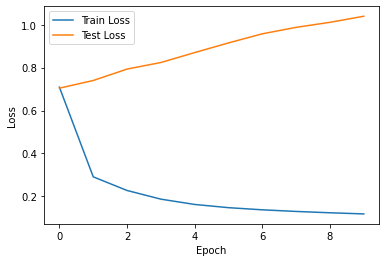

In [7]:
# plot the training and testing loss
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('./figures/loss.png')
plt.show()